# KNN - CLASSIFICATION

In [335]:
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [336]:
train_df = pd.read_csv("pp_train.csv")
test_df = pd.read_csv("pp_test.csv")

copy_train = train_df.copy()
copy_test = test_df.copy()

### Preprocessing delle variabili

##### Eliminazione variabili inutilizzabili

In [337]:
copy_train.columns

Index(['originalTitle', 'rating', 'startYear', 'endYear', 'runtimeMinutes',
       'awardWins', 'numVotes', 'totalImages', 'totalVideos', 'totalCredits',
       'criticReviewsTotal', 'titleType', 'awardNominationsExcludeWins',
       'canHaveEpisodes', 'isAdult', 'numRegions', 'userReviewsTotal',
       'is_Documentary', 'is_History', 'is_Adventure', 'is_Thriller',
       'is_Game-Show', 'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography',
       'is_Musical', 'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult',
       'is_Reality-TV', 'is_News', 'is_Action', 'is_Crime', 'is_Short',
       'is_Fantasy', 'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama',
       'is_Sport', 'is_War', 'is_Horror', 'is_Animation',
       'fill_runtimeMinutes', 'is_from_Oceania', 'is_from_North America',
       'is_from_South America', 'is_from_Asia', 'is_from_Africa',
       'is_from_Europe'],
      dtype='object')

In [338]:
copy_test.columns

Index(['originalTitle', 'rating', 'startYear', 'endYear', 'runtimeMinutes',
       'awardWins', 'numVotes', 'totalImages', 'totalVideos', 'totalCredits',
       'criticReviewsTotal', 'titleType', 'awardNominationsExcludeWins',
       'canHaveEpisodes', 'isAdult', 'numRegions', 'userReviewsTotal',
       'is_Western', 'is_Thriller', 'is_Horror', 'is_Animation', 'is_Family',
       'is_News', 'is_Sport', 'is_Reality-TV', 'is_Biography', 'is_Sci-Fi',
       'is_Fantasy', 'is_Documentary', 'is_Talk-Show', 'is_Drama', 'is_Music',
       'is_Game-Show', 'is_Adventure', 'is_Romance', 'is_Mystery', 'is_Short',
       'is_Action', 'is_Adult', 'is_History', 'is_Musical', 'is_Crime',
       'is_Film-Noir', 'is_War', 'is_Comedy', 'fill_runtimeMinutes',
       'is_from_South America', 'is_from_Oceania', 'is_from_Europe',
       'is_from_Asia', 'is_from_Africa', 'is_from_North America'],
      dtype='object')

##### Mapping variabile target

In [339]:
y = np.array(copy_train['titleType'])  # Il target originale

# Creiamo un dizionario che associa ogni categoria a un numero
y_map = {title: idx for idx, title in enumerate(copy_train['titleType'].unique())}

#aggiungo una nuova colonna
copy_train['titleType_encoded'] = copy_train['titleType'].map(y_map)
copy_test['titleType_encoded'] = copy_test['titleType'].map(y_map)

y_map  # Per vedere la mappatura delle categorie

{'tvEpisode': 0,
 'videoGame': 1,
 'movie': 2,
 'tvSeries': 3,
 'video': 4,
 'tvMiniSeries': 5,
 'short': 6,
 'tvMovie': 7,
 'tvSpecial': 8,
 'tvShort': 9}

In [340]:
copy_train["canHaveEpisodes"] = copy_train["canHaveEpisodes"].astype(int)
copy_test["canHaveEpisodes"] = copy_test["canHaveEpisodes"].astype(int)

#### Rimuoviamo titleType dato che è già stata mappata

In [341]:
copy_train = copy_train.drop(["originalTitle", "runtimeMinutes"], axis=1)
copy_test = copy_test.drop(["originalTitle", "runtimeMinutes"], axis=1)

In [342]:
copy_train = copy_train.drop(["titleType"], axis=1)
copy_test = copy_test.drop(["titleType"], axis=1)

#### Rimuoviamo endYear (fino a quando non capiamo come sostituirlo)

In [343]:
copy_train = copy_train.drop(["endYear"], axis=1)
copy_test = copy_test.drop(["endYear"], axis=1)

#### Encoding di titletype per multiclass classification task

In [344]:
# Extract target (y)
y_train = copy_train["titleType_encoded"].values  # Convert directly to NumPy
y_test = copy_test["titleType_encoded"].values  # Convert directly to NumPy

# Extract features (X) and convert to NumPy
X_train = copy_train.drop("titleType_encoded", axis=1).values
X_test = copy_test.drop("titleType_encoded", axis=1).values

#### Ulteriore rimozione attributi

In [345]:
copy_train = copy_train.drop(['is_Western', 'is_Thriller', 'is_Horror', 'is_Animation', 'is_Family',
       'is_News', 'is_Sport', 'is_Reality-TV', 'is_Biography', 'is_Sci-Fi',
       'is_Fantasy', 'is_Documentary', 'is_Talk-Show', 'is_Drama', 'is_Music',
       'is_Game-Show', 'is_Adventure', 'is_Romance', 'is_Mystery', 'is_Short',
       'is_Action', 'is_Adult', 'is_History', 'is_Musical', 'is_Crime',
       'is_Film-Noir', 'is_War', 'is_Comedy',
       'is_from_South America', 'is_from_Oceania', 'is_from_Europe',
       'is_from_Asia', 'is_from_Africa', 'is_from_North America', 'titleType_encoded', 'awardNominationsExcludeWins', "rating"], axis=1)

copy_test = copy_test.drop(['is_Western', 'is_Thriller', 'is_Horror', 'is_Animation', 'is_Family',
       'is_News', 'is_Sport', 'is_Reality-TV', 'is_Biography', 'is_Sci-Fi',
       'is_Fantasy', 'is_Documentary', 'is_Talk-Show', 'is_Drama', 'is_Music',
       'is_Game-Show', 'is_Adventure', 'is_Romance', 'is_Mystery', 'is_Short',
       'is_Action', 'is_Adult', 'is_History', 'is_Musical', 'is_Crime',
       'is_Film-Noir', 'is_War', 'is_Comedy',
       'is_from_South America', 'is_from_Oceania', 'is_from_Europe',
       'is_from_Asia', 'is_from_Africa', 'is_from_North America', 'titleType_encoded', 'awardNominationsExcludeWins', "rating"], axis=1)

In [346]:
copy_train.columns

Index(['startYear', 'awardWins', 'numVotes', 'totalImages', 'totalVideos',
       'totalCredits', 'criticReviewsTotal', 'canHaveEpisodes', 'isAdult',
       'numRegions', 'userReviewsTotal', 'fill_runtimeMinutes'],
      dtype='object')

In [347]:
copy_test.columns

Index(['startYear', 'awardWins', 'numVotes', 'totalImages', 'totalVideos',
       'totalCredits', 'criticReviewsTotal', 'canHaveEpisodes', 'isAdult',
       'numRegions', 'userReviewsTotal', 'fill_runtimeMinutes'],
      dtype='object')

#### Normalizzazione

In [348]:
numeric_tr = copy_train[['startYear', 'awardWins', 'numVotes', 'totalImages',
       'totalCredits', "totalVideos", 'criticReviewsTotal', 'canHaveEpisodes', 'isAdult',
       'numRegions', 'userReviewsTotal', "fill_runtimeMinutes"]].values

numeric_ts = copy_test[['startYear', 'awardWins', 'numVotes', 'totalImages',
       'totalCredits', "totalVideos", 'criticReviewsTotal', 'canHaveEpisodes', 'isAdult',
       'numRegions', 'userReviewsTotal', "fill_runtimeMinutes"]].values

In [349]:
X_train_numeric_log = np.log1p(numeric_tr)
X_test_numeric_log = np.log1p(numeric_ts)

In [350]:
scaler = StandardScaler()

# # Fittiamo SOLO su train e trasformiamo tutto
X_train_standardsc = scaler.fit_transform(X_train_numeric_log)
# X_val_standardsc = scaler.transform(X_val)

X_test_standardsc = scaler.transform(X_test_numeric_log)


In [351]:
minmax = MinMaxScaler()

# # Fitta e trasforma il training set in un solo passaggio
X_train_minmax = minmax.fit_transform(X_train_numeric_log)
# X_val_minmax = minmax.fit_transform(X_val)

# # Trasforma il test set (senza rifittare!)
X_test_minmax = minmax.transform(X_test_numeric_log)

In [352]:
# X_train_minmax = np.concatenate([minmaxtr, X_cat], axis=1)
# X_test_minmax = np.concatenate([minmaxts, X_cat], axis=1)

# X_train_standardscc = np.concatenate([standardsctr, X_cat], axis=1)
# X_test_standardsc = np.concatenate([standardscts, X_cat], axis=1)

## KNN

### RandomizedSearch per trovare gli iperparametri

In [353]:
# import numpy as np
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
# from scipy.stats import randint

# # Define the parameter distributions
# #general practice: k = sqrt(N) where N is the number of samples in the training dataset.

# param_distributions = {
#     "n_neighbors": np.arange(1, X_train.shape[0]//2),  
#     "weights": ["uniform", "distance"],
#     "metric": ["euclidean", "cityblock"]
# } 

# # Create the RandomizedSearchCV object
# random_search = RandomizedSearchCV(
#     KNeighborsClassifier(),
#     param_distributions=param_distributions,
#     n_iter=100,  # Number of parameter settings that are sampled
#     cv=RepeatedStratifiedKFold(random_state=0),
#     n_jobs=-1,
#     refit=True,
#     random_state=42,
#     #verbose=1
# )

# # Fit the model
# #random_search.fit(X_val_standardsc, y_val)
# random_search.fit(X_train_minmax, y_train) 


# # Get the best model
# clf = random_search.best_estimator_

# # Print results
# print("\nBest parameters:", random_search.best_params_)
# print("Best cross-validation score: {:.4f}".format(random_search.best_score_))

In [354]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint

def optimize_knn(X_train, y_train, n_iter=100, cv=5, verbose=1):
    # Calculate reasonable k range based on square root rule
    # sqrt(N) is a common rule of thumb for KNN
    sqrt_n = int(np.sqrt(X_train.shape[0]))
    
    # Define parameter space with more focused ranges
    param_distributions = {
        "n_neighbors": np.arange(1, sqrt_n+1),  # Focus around sqrt(N)
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "cityblock"]
    }
    
    # Create the RandomizedSearchCV object with improved settings
    random_search = RandomizedSearchCV(
        KNeighborsClassifier(),
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42),  # Stratified k-fold is usually sufficient
        n_jobs=-1,
        refit=True,
        random_state=42,
        verbose=verbose,
        scoring='accuracy',  # Specify your preferred metric
        return_train_score=True  # Good for checking overfitting
    )
    
    # Fit the model
    random_search.fit(X_train_standardsc, y_train)
    
        # Show top 5 models to see parameter sensitivity
    results = random_search.cv_results_
    sorted_idx = np.argsort(results['rank_test_score'])
    print("\nTop 5 configurations:")
    for i in range(5):
        idx = sorted_idx[i]
        print(f"Rank {i+1}: {results['params'][idx]}")
        print(f"   Test score: {results['mean_test_score'][idx]:.4f}")
        print(f"   Train score: {results['mean_train_score'][idx]:.4f}")

    return random_search.best_estimator_, random_search.best_params_, random_search.best_score_

In [355]:
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (16431, 48)
Test data shape: (5478, 48)


In [356]:
best_knn, best_params, best_score = optimize_knn(X_train_standardsc, y_train)
# Create a new classifier with the optimized parameters
clf = KNeighborsClassifier(**best_params)
clf.fit(X_train_standardsc, y_train)
y_pred = clf.predict(X_test_standardsc)

Fitting 5 folds for each of 100 candidates, totalling 500 fits

Top 5 configurations:
Rank 1: {'weights': 'distance', 'n_neighbors': 11, 'metric': 'cityblock'}
   Test score: 0.8388
   Train score: 1.0000
Rank 2: {'weights': 'distance', 'n_neighbors': 13, 'metric': 'cityblock'}
   Test score: 0.8388
   Train score: 1.0000
Rank 3: {'weights': 'distance', 'n_neighbors': 17, 'metric': 'cityblock'}
   Test score: 0.8384
   Train score: 1.0000
Rank 4: {'weights': 'distance', 'n_neighbors': 16, 'metric': 'cityblock'}
   Test score: 0.8384
   Train score: 1.0000
Rank 5: {'weights': 'distance', 'n_neighbors': 31, 'metric': 'cityblock'}
   Test score: 0.8351
   Train score: 1.0000


##### Creating in validation set

In [357]:
# X_train2, X_val, y_train2, y_val = train_test_split(
#      X_train, y_train, test_size=0.2, random_state=32
# )

# X_train2 = training set --> 80% di X_train
# X_val = validation set --> 20% di X_train
# y_train2 e y_val sono i target corrispondenti (etichette) per i dati di addestramento e validazione

In [358]:
# print(X_train2.shape, X_val.shape, X_test.shape)

##### Predicting on test set

In [359]:
# clf = KNeighborsClassifier(weights="distance", n_neighbors=25, metric="cityblock")
# #clf.fit(X_train_minmax, y_train)
# clf.fit(X_train_standardsc, y_train)
# # y_pred = clf.predict(X_test_minmax)
# y_pred = clf.predict(X_test_standardsc)


In [360]:
print(type(y_pred))
print(y_pred.dtype)
print(set(y_test))  # Check if it's already numeric
print(set(y_pred))  # se qui manca una classe rispetto a sopra vuol dire che non l'ha riconosciuta 

# Evaluate performance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print(f"Test accuracy: {accuracy_score(y_test, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

<class 'numpy.ndarray'>
int64
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
{0, 1, 2, 3, 4, 5, 6, 7, 8}
Test accuracy: 0.8260313983205549

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1599
           1       0.10      0.02      0.03        94
           2       0.80      0.94      0.86      1877
           3       0.88      0.99      0.93       447
           4       0.67      0.42      0.52       250
           5       0.81      0.27      0.41        81
           6       0.87      0.89      0.88       766
           7       0.36      0.12      0.18       299
           8       0.20      0.02      0.04        49
           9       0.00      0.00      0.00        16

    accuracy                           0.83      5478
   macro avg       0.56      0.46      0.48      5478
weighted avg       0.79      0.83      0.80      5478



C:\Users\Gagia\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Gagia\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Gagia\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [361]:
# Calculate test accuracy (what you already have)
test_accuracy = accuracy_score(y_test, y_pred)

# Calculate training accuracy
y_pred = clf.predict(X_train_standardsc)
train_accuracy = accuracy_score(y_train, y_pred)

# Print both for comparison
print(f"Train accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

Train accuracy: 1.0000
Test accuracy: 0.8260


In [362]:
cf = confusion_matrix(y_test, y_pred)
sns.heatmap(cf, annot=True, cmap="Greens")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [5478, 16431]

### Checking the distribution of the variables btw train and test

In [ ]:
# For training set
train_distribution = pd.Series(y_train).value_counts().sort_index()
train_percentages = 100 * train_distribution / len(y_train)

# For test set
test_distribution = pd.Series(y_test).value_counts().sort_index()
test_percentages = 100 * test_distribution / len(y_test)

# Display side by side
comparison = pd.DataFrame({
    'Train Count': train_distribution,
    'Train %': train_percentages,
    'Test Count': test_distribution,
    'Test %': test_percentages
})
print(comparison)

   Train Count    Train %  Test Count     Test %
0         4698  28.592295        1599  29.189485
1          259   1.576289          94   1.715955
2         5535  33.686325        1877  34.264330
3         1375   8.368328         447   8.159912
4          792   4.820157         250   4.563709
5          224   1.363277          81   1.478642
6         2474  15.056905         766  13.983206
7          868   5.282697         299   5.458196
8          166   1.010285          49   0.894487
9           40   0.243442          16   0.292077


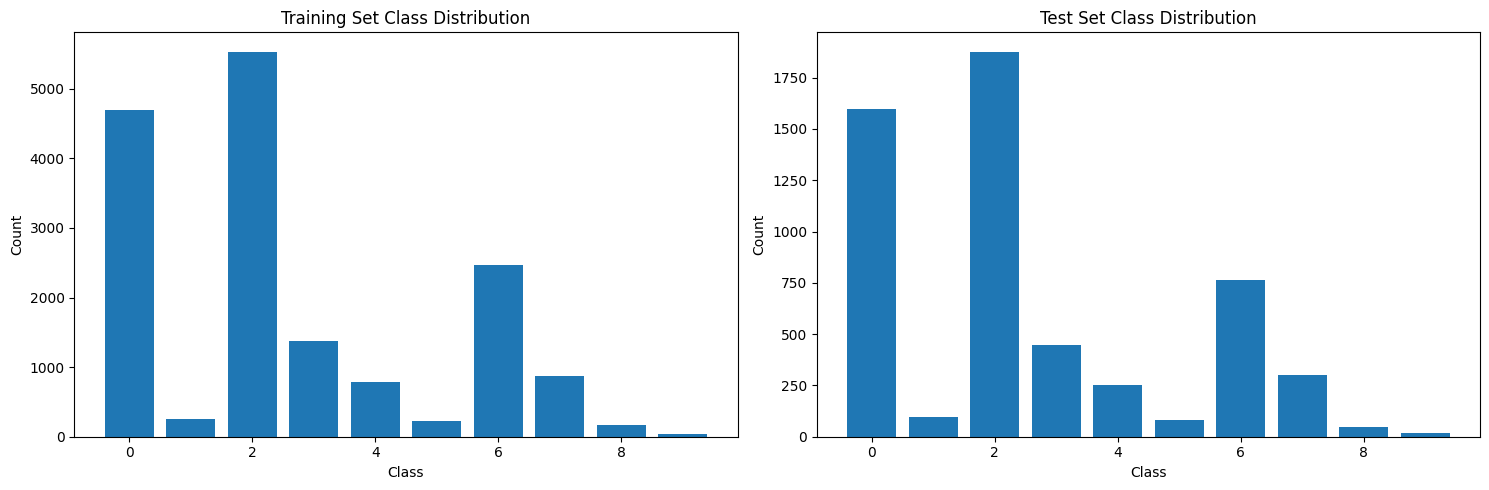

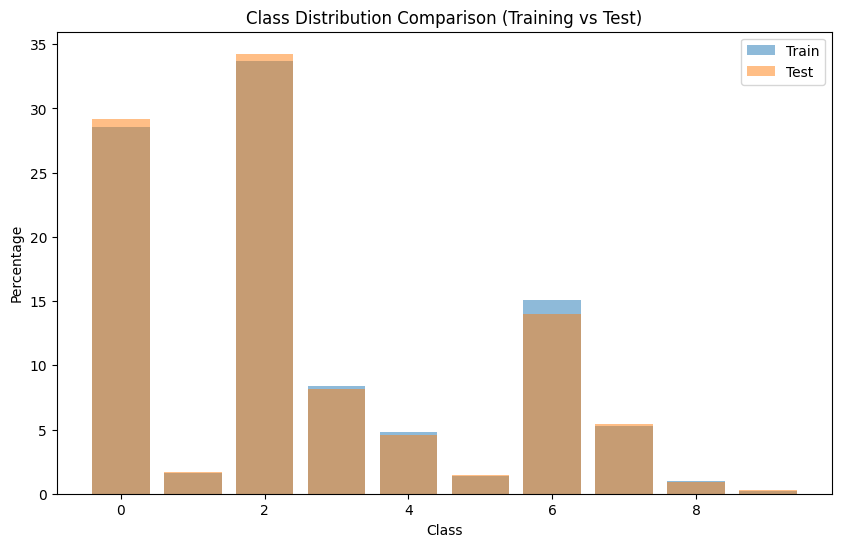

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# # # Plot training distribution
ax1.bar(train_distribution.index, train_distribution.values)
ax1.set_title('Training Set Class Distribution')
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')

# # # Plot test distribution
ax2.bar(test_distribution.index, test_distribution.values)
ax2.set_title('Test Set Class Distribution')
ax2.set_xlabel('Class')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()

# # Or plot percentages
plt.figure(figsize=(10, 6))
plt.bar(train_percentages.index, train_percentages.values, alpha=0.5, label='Train')
plt.bar(test_percentages.index, test_percentages.values, alpha=0.5, label='Test')
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.title('Class Distribution Comparison (Training vs Test)')
plt.legend()
plt.show()

##### Da quest'ultimo grafico (e dal report qui sopra) emerge che la distribuzione delle classi tra train e test non ha tutta questa discrepanza quindi potrebbe non essere questa la motivazione delle bad performances sul test